<a href="https://colab.research.google.com/github/SergioHR11/ProcesamientoDeImagenesAvanzado/blob/dev/Proyecto_Procesamiento_De_Imagenes_Avanzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------------------------------------------------------------
                                       Carga de Librerías
-------

In [ ]:
import numpy as np # linear algebra
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage.segmentation import clear_border
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from skimage.filters import frangi, hessian
import _pickle as cPickle
import cv2
from scipy.ndimage.filters import gaussian_filter
from sklearn.mixture import GaussianMixture as GMM

-------------------------------------------------------------------------
                                   Algoritmo de Segmentación Pulmonar 
-------

In [ ]:
def get_segmented_lungs(raw_im, plot=False):
    im=raw_im.copy()
    '''Esta funcion segmenta los pulmones de un corte en 2D sobre el plano Axial'''
    '''Step 1: Conversión a imagen binaria.'''
    
    binary = im < -400

    '''Step 2: Eliminar regiones conectadas a los bordes'''
    cleared = clear_border(binary)

    '''Step 3: Etiquetado de cuerpos'''
    label_image = label(cleared)
    
    ''' Step 4: Mantener los 2 cuerpos de mayor area'''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    
    ''' Step 5: Operacion de Erosion con un disco de radio 2'''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    
    '''Step 6: Cierre Binario'''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    step6 = binary 
    
    '''Step 7: Rellenado de los pequeños agujeros dentro de la máscara binaria'''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
        
    '''Step 8: Segmentar pulmon con la mascara obtenida'''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
        
    return binary, step6, im

-------------------------------------------------------------------------
                                Funciones Auxiliares y de Segmentación
-------------------------------------------------------------------------

In [ ]:

#-------------------------------------- Modelo de Mezclas Gaussianas GMM ---------------------
def plotClassGMM(gmm_labels, original_shape, c):
    classGMM = gmm_labels == c
    segmentedClass = classGMM.reshape(original_shape[0], original_shape[1])
    plt.figure(1)
    plt.imshow(segmentedClass, cmap=plt.cm.bone) 
    plt.axis('off')
    return segmentedClass

#-------------------------------------- Segmerntacion y Mascaras: Pulmones y vasculatura --------------------------------------------
''' Obtiene la mascara vascular de un corte 2D '''
def create_vessel_mask(vessels, denoise=False):
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    
    return vessels

''' Dilata la mascara vascular y cuantiza su densidad aplicando un filtro Gaussiano dado un Kernel'''
def blurrVessels(vesselMask, kernel):
    vesselsDilated = cv2.dilate(vesselMask, kernel, iterations=1) 
    blurr = gaussian_filter( vesselsDilated  , sigma=8)
    greyBlurr = ((blurr - blurr.min()) * (1/(blurr.max() - blurr.min()) * 255)).astype('uint8')
    
    return greyBlurr

''' Asigna un valor de pixel especifico al corte pulmonar segmentado dada una mascara vascular'''
#En este caso, se asigna el valor de pixel mas bajo del corte debido a que proporciona mejores  
#resultados en el filtrado Hessiano y de Frangi
def deleteVessel(lung_slice, vesselMask):
    lungWOvessel = lung_slice
    vesselIndexs = np.where(vesselMask == 0)

    for i in range(len(vesselIndexs[0])):
        lungWOvessel[ vesselIndexs[0][i] ][ vesselIndexs[1][i] ] = np.amin(lung_slice)
        
    return lungWOvessel

''' Obtiene las mascaras Pulmonares y Vasculares, así como la segmentación Pulmonar por cada corte 2D'''
def segmentacionPulmonar(rutaOriginal):
    print("Obteniendo mascaras: Pulmonares, Vasculares y Segmentación Pulmonar")
    lung = nib.load(rutaOriginal)
    lung_data = lung.get_fdata()
    x,y,z = lung_data.shape
    lungsSegmentation = np.ones((x,y,z))
    lungsMask = np.zeros((x,y,z))
    vesselMask = np.zeros((x,y,z))
    
    for sliceImg in range(z):
        lung_slice = lung_data[:, :, sliceImg]
        final, binary, s8 = get_segmented_lungs(lung_slice, False)
        
        lungsMask[:,:,sliceImg] = binary
        
        get_high_vals = binary == 0
        lung_slice[get_high_vals] = 0
        lungsSegmentation[:,:,sliceImg] = lung_slice
        
        vesselMask[:,:,sliceImg] = create_vessel_mask(lung_slice, denoise=True)
        
    print("Mascaras obtenidas")
    return lungsSegmentation, lungsMask, vesselMask

-------------------------------------------------------------------------
                              Lectura de Imagen  de CT y obtención de Máscaras 
-------

In [ ]:
ruta = "./datasets/lola11/NII/lola11-01.nii"
lungSegmentation,lungMask, vesselMask = segmentacionPulmonar(ruta)

Obteniendo mascaras: Pulmonares, Vasculares y Segmentación Pulmonar
Mascaras obtenidas


-------------------------------------------------------------------------
                                       Escritura de Datos 
-------

In [ ]:
#Se escriben las máscaras en archivos para no repetir el proceso de segmentacion para posteriores procesos
cPickle.dump( lungSegmentation, open( "./datasets/lola11/NII/Mascaras/LS_lola11-01.pkl", "wb" ) )
cPickle.dump( lungMask, open( "./datasets/lola11/NII/Mascaras/LM_lola11-01.pkl", "wb" ) )
cPickle.dump( vesselMask, open( "./datasets/lola11/NII/Mascaras/VM_lola11-01.pkl", "wb" ) )

----------------------------------------------------------------------------------------------------
                                          Lectura de Datos
-------

In [ ]:
#Se leen los archivos tipo numpy donde se almacenan las máscaras
LSload = cPickle.load( open( "./datasets/lola11/NII/Mascaras/LS_lola11-01.pkl", "rb" ) )
LMload = cPickle.load( open( "./datasets/lola11/NII/Mascaras/LM_lola11-01.pkl", "rb" ) )
VMload = cPickle.load( open( "./datasets/lola11/NII/Mascaras/VM_lola11-01.pkl", "rb" ) )
#Lectura y obtención informacion de la imagen CT
lung = nib.load("./datasets/lola11/NII/lola11-01.nii")
lung_data = lung.get_fdata()
x,y,z = lung_data.shape

print("Dimensiones de la CT: ({},{},{})".format(x,y,z))

Dimensiones de la CT: (421,313,464)


-------
                                Procesamiento de la Vasculatura
---

In [ ]:
#Cuantificacion de densidad Vascular sobre el plano Sagital (Dilatacion y Filtro Gaussiano)

vesselsBlurr = np.ones((x,y,z))
for sliceImg in range(x):
    vesselsBlurr[sliceImg,:,:] = blurrVessels(VMload[sliceImg,:,:], np.ones((3,3), np.uint8))


C:\Users\zergi\AppData\Local\Temp/ipykernel_20100/1909278506.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  greyBlurr = ((blurr - blurr.min()) * (1/(blurr.max() - blurr.min()) * 255)).astype('uint8')
C:\Users\zergi\AppData\Local\Temp/ipykernel_20100/1909278506.py:23: RuntimeWarning: invalid value encountered in multiply
  greyBlurr = ((blurr - blurr.min()) * (1/(blurr.max() - blurr.min()) * 255)).astype('uint8')


In [ ]:
#Mascara de Mapa de calor a partir del valor de intesidad de pixel: 25
maskVesselsBlurr = vesselsBlurr[lung_slice,:,:] < 25
#Mascara vascular mezclada con la mascara pulmonar
mvmp = maskVesselsBlurr + LMload[lung_slice,:,:]
mvmp = mvmp > 1

------
                           Proceo de filtrado sobre un Corte en plano sagital 2D
----

In [ ]:
#Numero de Slice sobre el plano Sagital sobre el cual se trabajará
lung_slice =  60 #60,100

In [ ]:
#Seteamos un valor especifico de pixel con base en la mascara del Mapa de calor sobre el corte Pulmonar 
lsWOmvb = deleteVessel(np.copy(LSload[lung_slice,:,:]), maskVesselsBlurr)

In [ ]:
#Aplicamos filtrado Hessiano y de Frangi sobre el corte seteado con el Mapa de Calor
frangiLung = frangi(lsWOmvb)
hessianLung = hessian(lsWOmvb)

#A las imagenes filtradas les restamos la mascaracon el Mapa de calor para quedarnos unicamente con regiones de interes
flMlsWOmvb = np.copy(frangiLung)
get_high_vals = mvmp == 0
flMlsWOmvb[get_high_vals] = 0

hlMlsWOmvb = np.copy(hessianLung)
get_high_vals = mvmp == 0
hlMlsWOmvb[get_high_vals] = 0


C:\Users\zergi\AppData\Local\Temp/ipykernel_20100/1421784789.py:3: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  hessianLung = hessian(lsWOmvb)


-----
                                Resultados Visuales de Preprocesamiento: 
----

*Segmentación (Pulmonar, Vascular), Mapa de Calor, Filtrado(Hessiano y Frangi)*

(-0.5, 463.5, 312.5, -0.5)

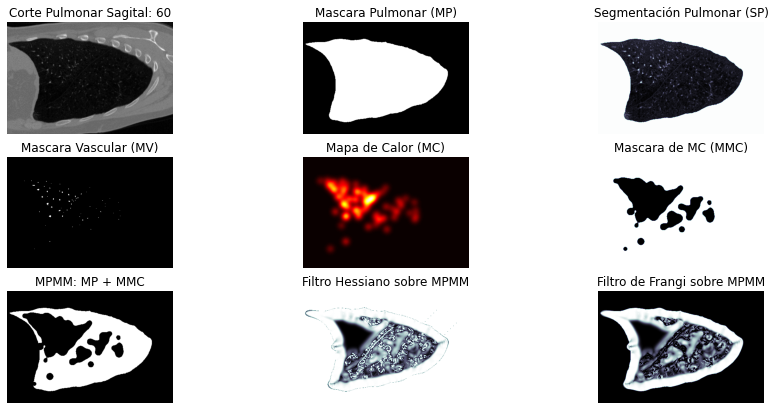

In [ ]:
fig = plt.figure(figsize=(15, 7))
rows = 3
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(lung_data[lung_slice,:,:], cmap=plt.cm.gray)
plt.title('Corte Pulmonar Sagital: {}'.format(lung_slice))
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(LMload[lung_slice,:,:], cmap=plt.cm.gray)
plt.title('Mascara Pulmonar (MP)')
plt.axis('off')

fig.add_subplot(rows, columns, 3)
plt.imshow(LSload[lung_slice,:,:], cmap=plt.cm.bone)
plt.title('Segmentación Pulmonar (SP)')
plt.axis('off')


fig.add_subplot(rows, columns, 4)
plt.imshow(VMload[lung_slice,:,:], cmap=plt.cm.gray)
plt.title('Mascara Vascular (MV)')
plt.axis('off')

fig.add_subplot(rows, columns, 5)
plt.imshow(vesselsBlurr[lung_slice,:,:], cmap='hot') 
plt.title('Mapa de Calor (MC)')
plt.axis('off')

fig.add_subplot(rows, columns, 6)
plt.imshow(maskVesselsBlurr, cmap=plt.cm.bone) 
plt.title('Mascara de MC (MMC)')
plt.axis('off')


fig.add_subplot(rows, columns, 7)
plt.imshow(mvmp, cmap=plt.cm.gray)
plt.title('MPMM: MP + MMC')
plt.axis('off')

fig.add_subplot(rows, columns, 8)
plt.imshow(hessianLung, cmap=plt.cm.bone) 
plt.title('Filtro Hessiano sobre MPMM')
plt.axis('off')

fig.add_subplot(rows, columns, 9)
plt.imshow(frangiLung, cmap=plt.cm.bone) 
plt.title('Filtro de Frangi sobre MPMM')
plt.axis('off')



----
                                Clusterización (Segmentación) con GMM:
---                                
Modelo de Mezclas Gaussianas usando el algoritmo de Maximización de Expectativa
----

(-0.5, 463.5, 312.5, -0.5)

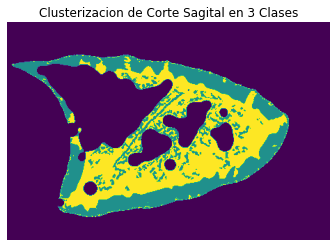

In [ ]:
#Aplanamos el corte 2D de M x N a 1D de MN
hessianLungGMM = hlMlsWOmvb.reshape((-1,1))
#Asignamos el numero de Clases con distribucion Gaussianas = 3 con una covarianza diagonal
#donde cada componente Gaussiana tiene su propia matriz de covarianza y entrenamos el Modelo
gmm_model = GMM(n_components = 3, covariance_type = 'diag').fit(hessianLungGMM)
#Realizamos las predicciones de Clase
gmm_labels = gmm_model.predict(hessianLungGMM)

#Reconstruimos el corte 2D con las predicciones hechas por el modelo
original_shape = hlMlsWOmvb.shape
segmented = gmm_labels.reshape(original_shape[0], original_shape[1])
plt.figure(1)
plt.imshow(segmented) 
plt.title("Clusterizacion de Corte Sagital en 3 Clases")
plt.axis('off')

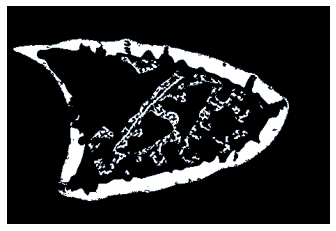

In [ ]:
# (0, 1, 2) son las clases predichas
'''La clase "1" conserva las regiones del parenquima y las fisuras, pero clusteriza los bordes pulmonares 
como parte de las regiones de interes, lo cual en el proceso de filtrado queda descartado'''
#Se pueden visulizar por separadas las imagenes con las distintas clases pero la clase 1 es la que se usará
#en los siguientes procesos
segmentedClass = plotClassGMM(gmm_labels, original_shape, 1)

In [ ]:
''' Se obtiene una mascara de las regiones de interes del filtrado de Frangi inviertiendo las regiones 
de no interes. Nos permite eliminar los bordes pulmonares y mantenerlas fisuras y el resto del parenquima
Pulmonar '''
fp_FrangiMask = flMlsWOmvb > 0
fp_FrangiMask = fp_FrangiMask^1

""" Se calcula la interseccion entre la mascara de regiones de interes de Frangi y la clase 1 del GMM-
Nos permite eliminar las regiones de lso bordes pulmonares """
#Calculamos la interseccion
fpFM_SC = cv2.bitwise_and(fp_FrangiMask*1, segmentedClass*1)


""" Sobreponemos la mascara de interseccion sobre el corte Sagital pulmonar, lo cual no devolverá los 
píxeles con mayor probabilidad de ser Fisuras con base en los Filtrados"""
lung_sliceGMM_S1 = np.copy(lung_data[lung_slice,:,:])
get_high_valsGMM = fpFM_SC == 0
lung_sliceGMM_S1[get_high_valsGMM] = 0


--------
                    Resultados Visuales de Clusterización con GMM y EM
-----

(-0.5, 463.5, 312.5, -0.5)

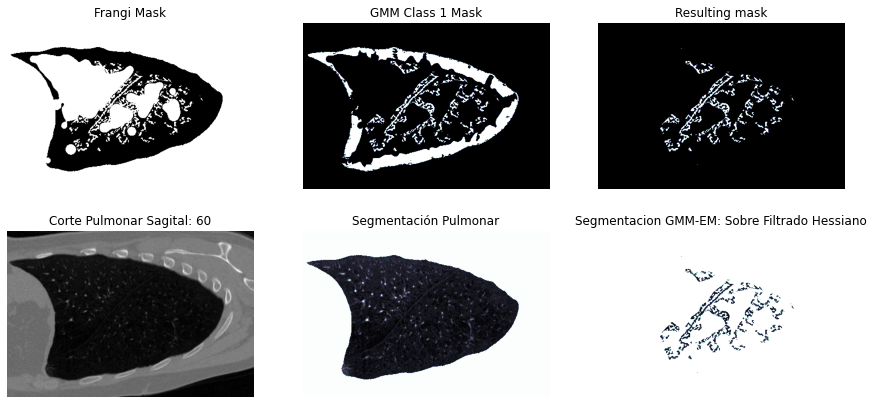

In [ ]:
fig = plt.figure(figsize=(15, 7))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(fp_FrangiMask, cmap=plt.cm.gray)
plt.title("Frangi Mask")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(segmentedClass, cmap=plt.cm.bone)
plt.title("GMM Class 1 Mask")
plt.axis('off')

fig.add_subplot(rows, columns, 3)
plt.imshow(fpFM_SC, cmap=plt.cm.bone) 
plt.title("Resulting mask")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(lung_data[lung_slice,:,:], cmap=plt.cm.gray)
plt.title('Corte Pulmonar Sagital: {}'.format(lung_slice))
plt.axis('off')

fig.add_subplot(rows, columns, 5)
plt.imshow(LSload[lung_slice,:,:], cmap=plt.cm.bone)
plt.title('Segmentación Pulmonar')
plt.axis('off')

fig.add_subplot(rows, columns, 6)
plt.imshow(lung_sliceGMM_S1*LMload[lung_slice,:,:], cmap=plt.cm.bone) 
plt.title('Segmentacion GMM-EM: Sobre Filtrado Hessiano')
plt.axis('off')